<a href="https://colab.research.google.com/github/Wastfulajr/NetGuard/blob/Michael/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Support vector machine model

In [1]:
import pandas as pd
import requests
import zipfile
import numpy as np
import io

# Download and load the dataset
dfs = []
FILE_DOWNLOAD_URL = "http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/GeneratedLabelledFlows.zip"

response = requests.get(FILE_DOWNLOAD_URL)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    for file in z.namelist()[1:]:
        with z.open(file) as f:
            dfs.append(pd.read_csv(f, encoding='cp1252'))

df = pd.concat(dfs, ignore_index=True)

# Quick data check
print("loaded data")

/tmp/ipython-input-2746754490.py:15: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f, encoding='cp1252'))


loaded data


RANDOMIZATION INTO FOLDS

In [2]:
#RANDOMIZATION INTO FOLDS


#This code should work however too much memory to execute

n = len(df)
folds = np.tile(np.arange(1, 11), int(np.ceil(n/10)))[:n]
np.random.shuffle(folds)   # randomize order *in place*
df["Fold"] = folds
print(df[[" Protocol", " Destination Port", " Label", "Fold"]].head(20))

#check fold counts to make sure equal amount randomzied
fold_counts = df["Fold"].value_counts().sort_index()
print(fold_counts)


     Protocol   Destination Port   Label  Fold
0         6.0               80.0  BENIGN     6
1         6.0              389.0  BENIGN     5
2         6.0               88.0  BENIGN     1
3         6.0              389.0  BENIGN     8
4         6.0               88.0  BENIGN     6
5         6.0              389.0  BENIGN     9
6         6.0               88.0  BENIGN     2
7         6.0               80.0  BENIGN     8
8         6.0            49666.0  BENIGN     4
9         6.0            49413.0  BENIGN     8
10        6.0               88.0  BENIGN     3
11        6.0              389.0  BENIGN     8
12        6.0             3268.0  BENIGN     5
13        6.0              443.0  BENIGN     9
14        6.0              443.0  BENIGN     3
15        6.0            49666.0  BENIGN     9
16        6.0              135.0  BENIGN     4
17        6.0            49666.0  BENIGN     5
18        6.0              135.0  BENIGN     6
19        6.0            49441.0  BENIGN     8
Fold
1     31

HYPERPARAMETER TUNING: RBF

In [ ]:
# FINDING BEST PARAMETERS
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.utils import resample

# using only first fold estimated time - 10 minutes
df_fold1 = df[df["Fold"] == 1].copy()
print("Using only Fold 1 data:", df_fold1.shape)

#uncomment this for full dataset usage will cost more
#estimated time ~ long
#df_fold1 = df;

# prep data
X = df_fold1.drop(columns=[' Label'])
y = df_fold1[' Label']
X = X.select_dtypes(include=['number'])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

class_counts = y.value_counts()
single_sample_classes = class_counts[class_counts < 2].index
if len(single_sample_classes) > 0:
    print(f"Removing classes with single samples for stratification: {list(single_sample_classes)}")
    X = X[~y.isin(single_sample_classes)]
    y = y[~y.isin(single_sample_classes)]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=0.2, stratify=y_train, random_state=42
)

# param grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

svm = SVC(random_state=42)
search = HalvingGridSearchCV(
    svm,
    param_grid=param_grid,
    factor=2,
    cv=2,
    n_jobs=-1,
    verbose=0, #change to 2 if you want iteration printing
    scoring='accuracy'
)


search.fit(X_tune, y_tune)

print("\n Best parameters found:") #use c.searc.best_params_['C'] when it needs to be used
print(search.best_params_)

Using only Fold 1 data: (311935, 86)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea


 Best parameters found:
{'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


Takes away the folds essentially

In [5]:
df_fold1 = df[df["Fold"] == 1].copy()
print("Using only Fold 1 data:", df_fold1.shape)

Using only Fold 1 data: (311935, 86)


Paramters found at full dataset analysis
{'C': 100, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}

In [6]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# we only want to use 1 fold for testing
#commetn this out to use full dataset
#df_fold1 = df[df["Fold"] == 1].copy()
#print("Using only Fold 1 data:", df_fold1.shape)



#data prep
X = df_fold1.drop(columns=[' Label'])
y = df_fold1[' Label']
X = X.select_dtypes(include=['number'])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]  # Keep labels aligned

class_counts = y.value_counts()
single_sample_classes = class_counts[class_counts < 2].index
if len(single_sample_classes) > 0:
    print(f"Removing classes with single samples for stratification: {list(single_sample_classes)}")
    X = X[~y.isin(single_sample_classes)]
    y = y[~y.isin(single_sample_classes)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# change to 0.1 for slightly better learning but might cost more
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# here =========================================== this should be the best values from tuning above
print("applying hyperParameter tuning to C and Gamma, and class_weight, using RBF")
svm_clf = SVC(kernel='rbf', class_weight=None, C=100, gamma='scale', random_state=42)
print("Training SVM on Fold 1...")
svm_clf.fit(X_train, y_train)
# here ===========================================

y_pred = svm_clf.predict(X_test)



applying hyperParameter tuning to C and Gamma, and class_weight, using RBF
Training SVM on Fold 1...


Print

Classification report

In [7]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.99      0.98      0.99     45393
                       Bot       0.00      0.00      0.00        36
                      DDoS       0.99      0.97      0.98      2566
             DoS GoldenEye       0.99      0.92      0.95       202
                  DoS Hulk       0.99      0.91      0.95      4620
          DoS Slowhttptest       0.92      0.98      0.95       113
             DoS slowloris       0.98      0.98      0.98       121
               FTP-Patator       0.93      0.99      0.96       161
                  PortScan       0.83      1.00      0.91      3173
               SSH-Patator       0.95      0.87      0.91       119
  Web Attack – Brute Force       0.00      0.00      0.00        28
Web Attack – Sql Injection       0.00      0.00      0.00         1
          Web Attack – XSS       0.00      0.00      0.00        12

                  accuracy                    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


for finding optimization

confusion matrix - uses seaborn

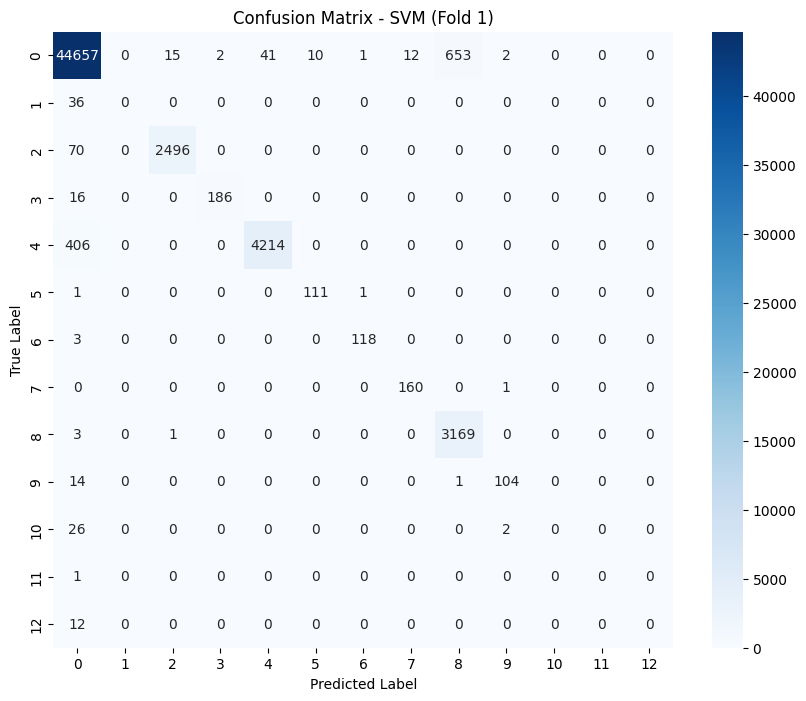

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM (Fold 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Plane visualization PCA projection